In [9]:
import matlab.engine

In [27]:
eng = matlab.engine.start_matlab()

In [11]:
import numpy as np
from scipy import fftpack
import tensorly as tl 
import time
from tensorly.decomposition import tucker
import tensorsketch
from tensorsketch import util
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle 
import simulation
plt.style.use('seaborn-paper')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import scipy.io

In [12]:
MARKER_LIST = ["s", "x", "o","+","*","d","^"]

In [8]:
Y= tensorsketch.util.square_tensor_gen(100,5,noise_level=0.1, typ = 'lk')[0]

In [13]:
Ynew = matlab.double(Y.tolist())

In [14]:
eng.tucker_ts_err(Ynew,matlab.int16([5,5,5]),250,1250,1e-4, 100)

0.10897833128726149

In [15]:
eng.tucker_als_err(Ynew,matlab.int16([5,5,5]),1e-4,100)

0.09943503893217365

In [16]:
eng.tucker_ttmts_err(Ynew,matlab.int16([5,5,5]),250,1250,1e-4, 100)

0.44953797095931863

In [22]:
eng.tucker_ts_err(Ynew,matlab.int16([5,5,5]),10,21,1e-4, 100)

0.9545635967818361

In [23]:
eng.tucker_als_err(Ynew,matlab.int16([5,5,5]),1e-4,100)

0.0994350389321735

In [24]:
eng.tucker_ttmts_err(Ynew,matlab.int16([5,5,5]),10,21,1e-4, 100)

1.8452905767964733

In [13]:
def gen_sparse_ten(n,nnz,r, dim = 3,noise_level = 1e-3):
    density = (1 - (1 - nnz**(1/dim)/n)**(1/r))*r
    core_tensor = np.random.normal(0,1,[r for _ in range(dim)])
    arms = []
    tensor = core_tensor
    for i in np.arange(dim): 
        arm =  np.random.normal(0,1,size = (n,r))
        arm = arm*np.random.binomial(1,density,size=(n,r))
        arms.append(arm)
        tensor = tl.tenalg.mode_dot(tensor, arm, mode=i) 
    tensor0 = tensor
    tensor = tensor + np.random.normal(0,1,size = [n for _ in range(dim)])*noise_level
    return tensor, tensor0 

In [64]:
testdata = gen_sparse_ten(100, 1000, 5)

0.10425818819511601


In [21]:
print(rerr_hooi )
print(rerr_twopass)
print(rerr_onepass)

0.09943503893217324
0.21695594448946734
0.2853598047546691


In [14]:
def fig1_reprun(gen_type,Ks,nnz, r0 =5, r = 8, noise_level = 1e-3,n = 200, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    eng = matlab.engine.start_matlab()
    ks = Ks*r
    ss = 2*ks+1
    hooi_rerr = np.zeros((sim_runs, len(ks)))
    two_pass_rerr = np.zeros((sim_runs,len(ks)))
    one_pass_rerr = np.zeros((sim_runs,len(ks)))
    ts_rerr = np.zeros((sim_runs, len(ks)))
    ttmts_rerr = np.zeros((sim_runs, len(ks)))
    for i in range(sim_runs): 
        for idx, K in enumerate(Ks): 
            k = ks[idx]
            s = ss[idx]
            Y  = gen_sparse_ten(n,nnz,r0,dim,noise_level)[0]
            Ymatlab = matlab.double(Y.tolist())
            print(K)
            print(r)
            print(K*r**(dim-1))
            J1 = matlab.int64([K*r**(dim-1)])
            J2 = matlab.int64([K*r**dim])
            rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
            tapprox = tensorsketch.tensor_approx.TensorApprox( Y, [r for _ in range(dim)], ks = [k for _ in range(dim)], \
                ss = [s for _ in range(dim)], random_seed = 1, rm_typ = 'gprod', store_phis = True) 
            Y_hat_hooi, _, _, _, (_, recover_time) = tapprox.tensor_approx('hooi')
            Y_hat_twopass, _, _, _, (_, recover_time) = tapprox.tensor_approx('twopass')
            Y_hat_onepass, _, _, _, (_, recover_time) = tapprox.tensor_approx('onepass')
            rerr_hooi = tensorsketch.util.eval_rerr(Y,Y_hat_hooi,Y)
            rerr_twopass = tensorsketch.util.eval_rerr(Y,Y_hat_twopass,Y)
            rerr_onepass = tensorsketch.util.eval_rerr(Y,Y_hat_onepass,Y)
            assert(rerr_als - rerr_hooi < 0.001)
            print(rerr_als)
            hooi_rerr[i,idx] = rerr_hooi
            two_pass_rerr[i,idx] = rerr_twopass
            one_pass_rerr[i,idx] = rerr_onepass
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
    sim_list = [hooi_rerr, two_pass_rerr,one_pass_rerr, ts_rerr, ttmts_rerr]
#    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim, rm_typ) +".pickle", "wb" ) )
    return sim_list

In [7]:
np.arange(2,10,2)

array([2, 4, 6, 8])

In [ ]:
sim_list = fig1_reprun('lk',np.arange(2,22,2), nnz = 100000, r0 =5, r = 8, noise_level = 1e-3,n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")

0.600208357273301
2
8
128


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
8.35083129843911e-05
0.600208357273301
4
8
256


In [150]:
np.mean(sim_list[0], axis = 0)

array([9.55952504e-05, 9.24382017e-05, 1.05037970e-04, 9.56320233e-05,
       9.57158722e-05, 9.05933593e-05, 9.41674087e-05, 9.46771549e-05,
       9.90436089e-05, 8.84542029e-05])

In [15]:
def avg_sim_list(sim_list): 
    sim_list_new = []
    for sims in sim_list: 
        sim_list_new.append(np.mean(sims, axis = 0)) 
    return sim_list_new
        

In [36]:
def fig1_repplot(sim_list,Ks,fontsize = 18): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    plt.figure(figsize=(6,5))
    ymaxs = []

    
    two_pass_result = (sim_list[1]/sim_list[0])
    one_pass_result = (sim_list[2]/sim_list[0])
    ts_result = (sim_list[3]/sim_list[0])
    ttmts_result = (sim_list[4]/sim_list[0])
    print(two_pass_result)
    plt.plot(Ks, two_pass_result, label = 'two pass', markersize = 10, marker = MARKER_LIST[0], markeredgewidth=1, markerfacecolor='None')
    plt.plot(Ks, one_pass_result, label = 'one pass', markersize = 10, marker = MARKER_LIST[1], markeredgewidth=1, markerfacecolor='None')
    plt.plot(Ks, ts_result, label = 'ts', markersize = 10, marker = MARKER_LIST[2], markeredgewidth=1, markerfacecolor='None')
    plt.plot(Ks, ttmts_result, label = 'ttmts', markersize = 10, marker = MARKER_LIST[3], markeredgewidth=1, markerfacecolor='None')

    alldata = np.concatenate(sim_list)
    ymaxs.append(max(alldata))
    plt.legend(loc = 'best')
    plt.xlabel('Ks')
    plt.ylabel('Relative Error')
    plt.minorticks_off()
    alldata = np.concatenate(sim_list)
    ymin = 0
    ymax = max(ymaxs)  
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else:
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.show()

In [17]:
avg_sim_list(sim_list)

NameError: name 'sim_list' is not defined

[ 6.71082612e-01  3.52356995e-01  2.09910409e-01  1.12612048e-01
  5.25251400e-02  8.94097147e-03 -1.55431223e-15 -1.11022302e-15
 -1.11022302e-16  3.10862447e-15]


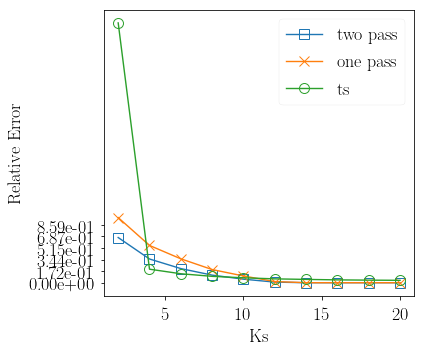

In [171]:
fig1_repplot(avg_sim_list(sim_list), np.arange(2,22,2))

In [18]:
def fig1_reprun_mem(gen_type,Ks,nnz, r0 =5, r = 8, noise_level = 1e-3,n = 200, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    eng = matlab.engine.start_matlab()
    ks = Ks
    ss = 2*ks+1
    hooi_rerr = np.zeros((sim_runs, len(ks)))
    two_pass_rerr = np.zeros((sim_runs,len(ks)))
    one_pass_rerr = np.zeros((sim_runs,len(ks)))
    ts_rerr = np.zeros((sim_runs, len(ks)))
    ttmts_rerr = np.zeros((sim_runs, len(ks)))
    for i in range(sim_runs): 
        for idx, K in enumerate(Ks): 
            k = ks[idx]
            s = ss[idx]
            Y  = gen_sparse_ten(n,nnz,r0, dim,noise_level)[0]
            Ymatlab = matlab.double(Y.tolist())
            J1 = matlab.int64([k])
            J2 = matlab.int64([s])
            rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
            tapprox = tensorsketch.tensor_approx.TensorApprox( Y, [r for _ in range(dim)], ks = [k for _ in range(dim)], \
                ss = [s for _ in range(dim)], random_seed = 1, rm_typ = 'gprod', store_phis = True) 
            Y_hat_hooi, _, _, _, (_, recover_time) = tapprox.tensor_approx('hooi')
            Y_hat_twopass, _, _, _, (_, recover_time) = tapprox.tensor_approx('twopass')
            Y_hat_onepass, _, _, _, (_, recover_time) = tapprox.tensor_approx('onepass')
            rerr_hooi = tensorsketch.util.eval_rerr(Y,Y_hat_hooi,Y)
            rerr_twopass = tensorsketch.util.eval_rerr(Y,Y_hat_twopass,Y)
            rerr_onepass = tensorsketch.util.eval_rerr(Y,Y_hat_onepass,Y)
            assert(rerr_als - rerr_hooi < 0.001)
            print(rerr_als)
            hooi_rerr[i,idx] = rerr_hooi
            two_pass_rerr[i,idx] = rerr_twopass
            one_pass_rerr[i,idx] = rerr_onepass
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
    sim_list = [hooi_rerr, two_pass_rerr,one_pass_rerr, ts_rerr, ttmts_rerr]
#    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim, rm_typ) +".pickle", "wb" ) )
    return sim_list

In [33]:
sim_list_mem = fig1_reprun_mem('lk',np.arange(10,40,5), nnz = 100000, r0 =5, r = 8, noise_level = 1e-3,n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")

0.5865601567031703


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.00021717963802819214
0.5865601567031703


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.00021718576701442645
0.5865601567031703


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.00018569547261572584
0.5865601567031703


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.00015915432159625963
0.5865601567031703


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.0001976658581156835
0.5865601567031703
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.00018285689557709215


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


In [34]:
sim_list_mem

[array([[0.00021714, 0.00021714, 0.00018566, 0.00015912, 0.00019763,
         0.00018281]]),
 array([[0.00067674, 0.00049862, 0.00032625, 0.00022331, 0.00026522,
         0.00024062]]),
 array([[0.00102378, 0.00068606, 0.00043365, 0.00027973, 0.00034616,
         0.00029371]]),
 array([[0.98270725, 0.97775802, 0.93764276, 0.95788945, 0.92327317,
         0.93744768]]),
 array([[4.05129089, 5.39191657, 3.33719535, 3.69224456, 2.5364845 ,
         3.31642444]])]

[1.13673322 0.83130435 0.56372305 0.33889711 0.29419688 0.27477465]


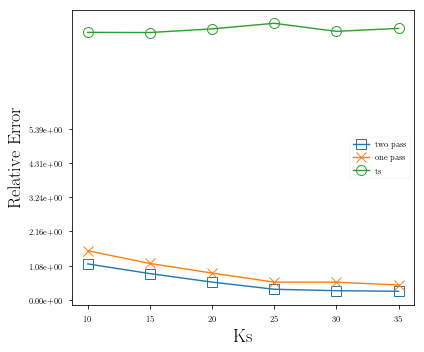

In [37]:
fig1_repplot(avg_sim_list(sim_list_mem), np.arange(10,40,5))

In [43]:
def fig5_reprun(gen_type,rs,nnz, noise_level = 1e-3,n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    eng = matlab.engine.start_matlab()
    r0 = 5 
    K = 10
    ks = 2*rs
    ss = 2*ks+1
    hooi_rerr = np.zeros((sim_runs, len(ks)))
    two_pass_rerr = np.zeros((sim_runs,len(ks)))
    one_pass_rerr = np.zeros((sim_runs,len(ks)))
    ts_rerr = np.zeros((sim_runs, len(ks)))
    ttmts_rerr = np.zeros((sim_runs, len(ks)))
    for i in range(sim_runs): 
        for idx, r in enumerate(rs): 
            k = ks[idx]
            s = ss[idx]
            Y  = gen_sparse_ten(n,nnz,r, dim,noise_level)[0]
            scipy.io.savemat('exp.mat', mdict={'arr': Y})
            Ymatlab = matlab.double(Y.tolist())
            J1 = matlab.int64([K*r**(dim -1)])
            J2 = matlab.int64([K*r**dim])
            print(K*r**dim,Y.shape,r,J1,J2)
            rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
            tapprox = tensorsketch.tensor_approx.TensorApprox( Y, [r for _ in range(dim)], ks = [k for _ in range(dim)], \
                ss = [s for _ in range(dim)], random_seed = 1, rm_typ = 'gprod', store_phis = True) 
            Y_hat_hooi, _, _, _, (_, recover_time) = tapprox.tensor_approx('hooi')
            Y_hat_twopass, _, _, _, (_, recover_time) = tapprox.tensor_approx('twopass')
            Y_hat_onepass, _, _, _, (_, recover_time) = tapprox.tensor_approx('onepass')
            rerr_hooi = tensorsketch.util.eval_rerr(Y,Y_hat_hooi,Y)
            rerr_twopass = tensorsketch.util.eval_rerr(Y,Y_hat_twopass,Y)
            rerr_onepass = tensorsketch.util.eval_rerr(Y,Y_hat_onepass,Y)
            assert(rerr_als - rerr_hooi < 0.001)
            print(rerr_als)
            hooi_rerr[i,idx] = rerr_hooi
            two_pass_rerr[i,idx] = rerr_twopass
            one_pass_rerr[i,idx] = rerr_onepass
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
    sim_list = [hooi_rerr, two_pass_rerr,one_pass_rerr, ts_rerr, ttmts_rerr]
#    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim, rm_typ) +".pickle", "wb" ) )
    return sim_list

In [44]:
sim_list_fig5 = fig5_reprun('lk',np.arange(5,20,4), nnz = 100000, noise_level = 1e-3,n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")

1250 (100, 100, 100) 5 [[250]] [[1250]]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0.0002131271761949289
7290 (100, 100, 100) 9 [[810]] [[7290]]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
8.205984405648543e-05
21970 (100, 100, 100) 13 [[1690]] [[21970]]


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
4.619791886523058e-05
49130 (100, 100, 100) 17 [[2890]] [[49130]]
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
2.9558236109536505e-05


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


In [45]:
avg_sim_list(sim_list_fig5)

[array([2.13127176e-04, 8.20598441e-05, 4.61979189e-05, 2.95582361e-05]),
 array([7.28942187e-04, 1.95010754e-04, 9.57761198e-05, 6.82463880e-05]),
 array([1.03885785e-03, 2.55833455e-04, 1.24140931e-04, 9.57992617e-05]),
 array([2.31431117e-04, 8.76689567e-05, 4.92012766e-05, 3.13445056e-05]),
 array([0.42955504, 0.36607189, 0.34633158, 0.33622904])]

[3.42022167 2.37644559 2.07316958 2.30887891]


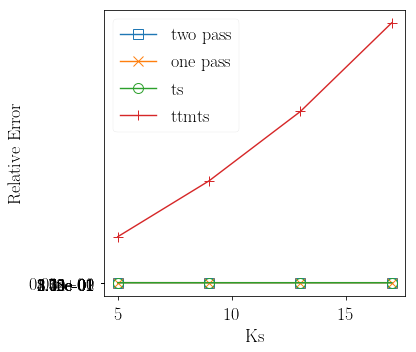

In [46]:
fig1_repplot(avg_sim_list(sim_list_fig5), np.arange(5,20,4))

In [15]:
rs = np.arange(5,15,2)

In [6]:
g_result = compare_rssim('lk',rs, 0.1, n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


In [8]:
g_result

[[array([[0.212435  , 0.1705914 , 0.14061831, 0.1284264 , 0.12296332]]),
  array([[0.30102944, 0.2265594 , 0.17628446, 0.15074677, 0.14406683]]),
  array([[0.09986076, 0.09986076, 0.09986076, 0.09986076, 0.09986076]])]]

In [83]:
gprod_result = compare_rssim('lk',rs, 0.1, n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100
0 100
1 100
2 100


Using numpy backend.
Using numpy backend.
Using numpy backend.


In [84]:
hooi_err = g_result[0][2][0]
g_err = g_result[0][1][0]
gprod_err = gprod_result[0][1][0]

In [85]:
scipy.io.loadmat('demo5.mat')['err_mat']

array([[0.0099912 , 0.00998417, 0.00997536, 0.0099639 , 0.00995045,
        0.00993575],
       [0.01084409, 0.01144262, 0.0125922 , 0.01454808, 0.03163583,
        0.17380953],
       [0.38261625, 0.53272152, 0.67548667, 0.78061856, 0.88568428,
        1.01080956]])

In [86]:
ts_err = scipy.io.loadmat('demo5.mat')['err_mat'][1,:]
ttmts_err = scipy.io.loadmat('demo5.mat')['err_mat'][2,:]

In [87]:
MARKER_LIST = ["s", "x", "o","+","*","d","^"]

In [88]:
n = 100

In [89]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
sim_list = []
plt.figure(figsize=(6,5))
ymaxs = []
g_logratio = [np.log(g_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
gprod_logratio = [np.log(gprod_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
ts_logratio = [np.log(ts_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
ttmts_logratio = [np.log(ttmts_err[i]/hooi_err[i]) for i in range(len(hooi_err))]

<Figure size 432x360 with 0 Axes>

In [90]:
print(g_logratio)
print(gprod_logratio)
print(ts_logratio)
print(ttmts_logratio)

[1.103431270304495, 0.8192303453097105, 0.5683221047677608, 0.4118246171567793, 0.36650046643577866]
[0.890208121361631, 0.8102790873358305, 0.6736691727950143, 0.584675770500923, 0.5378771851802769]
[-2.220156663645529, -2.1664321549450274, -2.0706988995213584, -1.9263176102010118, -1.1494865579943105]
[1.3432557285960551, 1.6742219989293146, 1.9116566164706434, 2.056309816201918, 2.1825837322706247]


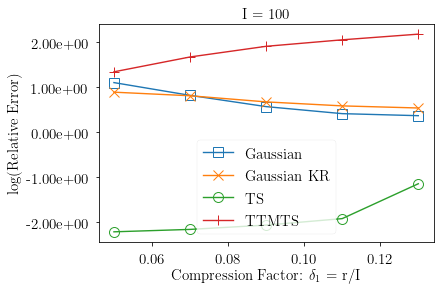

In [92]:
fontsize = 15
plt.plot(rs/n, g_logratio, label = 'Gaussian', markersize = 10, marker = MARKER_LIST[0], markeredgewidth=1, markerfacecolor='None') 
plt.plot(rs/n, gprod_logratio, label = 'Gaussian KR', markersize = 10, marker = MARKER_LIST[1], markeredgewidth=1, markerfacecolor='None') 
plt.plot(rs/n, ts_logratio, label = 'TS', markersize = 10, marker = MARKER_LIST[2], markeredgewidth=1, markerfacecolor='None') 
plt.plot(rs/n, ttmts_logratio, label = 'TTMTS', markersize = 10, marker = MARKER_LIST[3], markeredgewidth=1, markerfacecolor='None') 

plt.title("I = %s"%(n))
alldata = np.concatenate([g_logratio,gprod_logratio,ts_logratio,ttmts_logratio])

plt.legend(loc = 'best')
plt.xlabel('Compression Factor: $\delta_1$ = r/I')
plt.ylabel('log(Relative Error)')
plt.minorticks_off()
ymin = 0
ymax = max(alldata)  
def round_to_n(x,n): 
    if x == 0: 
        return 0
    else:
        return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
#ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
#plt.yticks(ticks)
plt.axes().title.set_fontsize(fontsize)
plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
plt.axes().xaxis.label.set_fontsize(fontsize)
plt.axes().yaxis.label.set_fontsize(fontsize)
plt.rc('legend',fontsize = fontsize)
plt.rc('xtick', labelsize = fontsize) 
plt.rc('ytick', labelsize = fontsize) 

In [17]:
ts_err = scipy.io.loadmat('demo6.mat')['err_mat'][1,:]
ttmts_err = scipy.io.loadmat('demo6.mat')['err_mat'][2,:]

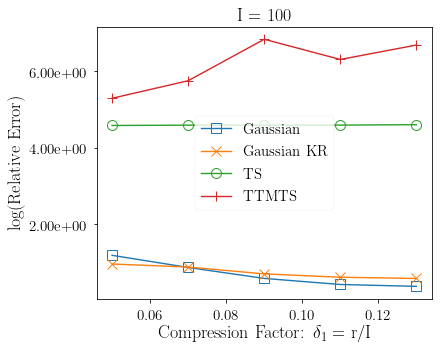

In [18]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
sim_list = []
plt.figure(figsize=(6,5))
ymaxs = []
g_logratio = [np.log(g_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
gprod_logratio = [np.log(gprod_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
ts_logratio = [np.log(ts_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
ttmts_logratio = [np.log(ttmts_err[i]/hooi_err[i]) for i in range(len(hooi_err))]
fontsize = 18
plt.plot(rs/n, g_logratio, label = 'Gaussian', markersize = 10, marker = MARKER_LIST[0], markeredgewidth=1, markerfacecolor='None') 
plt.plot(rs/n, gprod_logratio, label = 'Gaussian KR', markersize = 10, marker = MARKER_LIST[1], markeredgewidth=1, markerfacecolor='None') 
plt.plot(rs/n, ts_logratio, label = 'TS', markersize = 10, marker = MARKER_LIST[2], markeredgewidth=1, markerfacecolor='None') 
plt.plot(rs/n, ttmts_logratio, label = 'TTMTS', markersize = 10, marker = MARKER_LIST[3], markeredgewidth=1, markerfacecolor='None') 

plt.title("I = %s"%(n))
alldata = np.concatenate([g_logratio,gprod_logratio,ts_logratio,ttmts_logratio])

plt.legend(loc = 'best')
plt.xlabel('Compression Factor: $\delta_1$ = r/I')
plt.ylabel('log(Relative Error)')
plt.minorticks_off()
ymin = 0
ymax = max(alldata)  
def round_to_n(x,n): 
    if x == 0: 
        return 0
    else:
        return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
#ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
#plt.yticks(ticks)
plt.axes().title.set_fontsize(fontsize)
plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
plt.axes().xaxis.label.set_fontsize(fontsize)
plt.axes().yaxis.label.set_fontsize(fontsize)
plt.rc('legend',fontsize = fontsize)
plt.rc('xtick', labelsize = fontsize) 
plt.rc('ytick', labelsize = fontsize) 

In [24]:
test =tensorsketch.util.square_tensor_gen(dim = 3,n = 100,noise_level=0.1,r=5,typ='lk')

In [25]:
np.linalg.norm(test[0]- test[1])

0.7037434771342747

In [27]:
np.linalg.norm(test[1])

7.040640360060616

In [59]:
def square_tensor_gen(n, r, dim = 3,  typ = 'lk', noise_level = 0, seed = None):
    '''
    :param n: size of the tensor generated n*n*...*n
    :param r: rank of the tensor or equivalently, the size of core tensor
    :param dim: # of dimensions of the tensor, default set as 3
    :param typ: identity as core tensor or low rank as core tensor
    :param noise_level: sqrt(E||X||^2_F/E||error||^_F)
    :return: The tensor with noise, and The tensor without noise
    '''
    if typ == "lk":
        core_tensor = np.random.uniform(0,1,[r for _ in range(dim)])
        arms = []
        tensor = core_tensor
        for i in np.arange(dim):
            arm = np.random.normal(0,1,size = (n,r))
            arm, _ = np.linalg.qr(arm)
            arms.append(arm)
            tensor = tl.tenalg.mode_dot(tensor, arm, mode=i)
        true_signal_mag = np.linalg.norm(tensor)**2
        noise = np.random.normal(0, 1, np.repeat(n, dim))
        X = tensor + noise*np.sqrt((noise_level**2)*true_signal_mag/total_num)
        return X, tensor

In [60]:
r = 5
dim = 3
n = 100
noise_level = 0.01
total_num = np.power(n, dim)

core_tensor = np.random.uniform(0,1,[r for _ in range(dim)])
arms = []
tensor = core_tensor
for i in np.arange(dim):
    arm = np.random.normal(0,1,size = (n,r))
    arm, _ = np.linalg.qr(arm)
    arms.append(arm)
    tensor = tl.tenalg.mode_dot(tensor, arm, mode=i)
true_signal_mag = np.linalg.norm(tensor)**2
noise = np.random.normal(0, 1, np.repeat(n, dim))
X = tensor + noise*np.sqrt((noise_level**2)*true_signal_mag/total_num)

In [61]:
true_signal_mag

38.25357576373226

In [62]:
np.linalg.norm(X)

6.1852730363630295

In [71]:
np.linalg.norm(tl.tucker_to_tensor(core, factor))

6.184964316361341

In [70]:
np.linalg.norm(tl.tucker_to_tensor(core, factor)-X)

0.06179757031174959

In [64]:
core, factor = tucker(X,[5,5,5])
np.linalg.norm(tl.tucker_to_tensor(core, factor)-X)/np.linalg.norm(X)

0.009991082034445946

In [69]:
simu = simulation.Simulation(n, 5, 10, 21, 3, tensorsketch.util.RandomInfoBucket(random_seed=2), 'lk', 0.01,'g')
rerr_hooi, rerr_twopass, rerr_onepass = simu.run_sim()
rerr_hooi

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0.009975456331721212